# Land Cover Change: Houston Urban Growth.

## Introduction

Houston is one of the fastest growing cities in the United States. Over the 1990-2016 period, Harris county (which includes Houston downtown) experienced a 67% increase in population. On the ground, this has led to a strong increase in developed land for urban use. As a geospatial analyst for the Harris County board, you are being asked to explore trends in the Houston Metropolitan area and examine past land change to understand future land development in the county. To complete the task, you will process land cover data from the National Land Cover Database (NLCD) and examine land change in the area. You will also generate a first exploratory land change model using logistic regression to examine proximate factors (variables) that have influenced past location of development. All work must be repeatable and documented in a scripting environment to be shared with your team.

## Documentation and packages

First, we set up the code by providing information on the Authors, Creation dates, version by importing relevant python packages. Documenting and providing context and information within a script is important as it is often the case that code will be reused for other applications or other users/colleagues Good documentation improves code reproducibility as well.

In [19]:
#################################### Land Use and Land Cover Change #######################################
############################ Analyze Land Cover change in Houston #######################################
#This script performs analyses for the Exercise 4 of the AAG Course using aggregated NLCD values.
#The goal is to assess land cover change using two land cover maps in the Houston areas.
#Additional datasets are provided for the land cover change modeling. A model is built for Harris county.
#
#AUTHORS: Benoit Parmentier
#DATE CREATED: 01/07/2019
#DATE MODIFIED: 04/05/2019
#Version: 1
#PROJECT: AAG 2019 Geospatial Short Course
#TO DO:
#
#COMMIT: changes to modeling
#
#################################################################################################

###### Library used in this script

import gdal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import rasterio
import subprocess
import pandas as pd
import os, glob
from rasterio import plot
import geopandas as gpd
import descartes
import pysal as ps
from cartopy import crs as ccrs
from pyproj import Proj
from osgeo import osr
from shapely.geometry import Point
from collections import OrderedDict
import webcolors
import copy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


The list of packages above constains some of the most common packages used in geospatial data processing, wrangling and analyses. Notables spatial packages are "geopandas", "rasterio", "pysal", "gdal" and "shapely". Geopandas extends the "pandas" package to allow for the use of spatial data using a geometry column in a DataFrame object. It implements a version of the OGC Simple Feature model (https://www.opengeospatial.org/standards/sfa) using the "shapely" package to define the geometry of spatial objects. GDAL and Rasterio allow raster layers operations and processing including reprojection, distance compuation, mosaicing. The "skitlearn" package provides access to Machine Learning method in a unified API interface.. In this exercise, we use scikitlearn to model land cover change with a logistic regression.

## Functions

In the next part of the script, we declare all the functions used in the sripts. The first function builds an output directory. It is good practice to place functions at the beginning of a script or an external source file.

In [20]:

################ NOW FUNCTIONS  ###################

##------------------
# Functions used in the script 
##------------------

def create_dir_and_check_existence(path):
    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")


## Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).

In [21]:
############################################################################
#####  Parameters and argument set up ########### 

#ARGS 1
#in_dir = "/home/bparmentier/c_drive/Users/bparmentier/Data/python/Exercise_4/data"
in_dir = "/nfs/public-data/training"
#ARGS 2
#out_dir = "/home/bparmentier/c_drive/Users/bparmentier/Data/python/Exercise_4/outputs"
out_dir = "/research-home/bparmentier"
#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARGS 4
out_suffix = "exercise4_04052019" #output suffix for the files and ouptut folder
#ARGS 5
NA_value = -9999 # number of cores
#ARGS 6
file_format = ".tif"
#ARGS 7
#NLCD coordinate reference system: we will use this projection rather than TX.
CRS_reg = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
#ARGS 8
method_proj_val = "bilinear" # method option for the reprojection and resampling
#ARGS 9
gdal_installed = True #if TRUE, GDAL is used to generate distance files
		
### Input data files
#ARGS 10
rastername_county_harris = "harris_county_mask.tif" #Region of interest: extent of Harris County
#ARGS 11
elevation_fname = "srtm_Houston_area_90m.tif" #SRTM elevation
#ARGS 12
roads_fname = "r_roads_Harris.tif" #Road count for Harris county
	
### Aggreagate NLCD input files
 #ARGS 13
infile_land_cover_date1 = "agg_3_r_nlcd2001_Houston.tif"
#ARGS 14
infile_land_cover_date2 = "agg_3_r_nlcd2006_Houston.tif"
#ARGS 15
infile_land_cover_date3 = "agg_3_r_nlcd2011_Houston.tif"
#ARGS 16	
infile_name_nlcd_legend = "nlcd_legend.txt"
#ARGS 17
infile_name_nlcd_classification_system = "classification_system_nlcd_legend.xlsx"
#ARGS 18	
data_fname = 'r_variables_harris_county_exercise4_02072019.txt'
#ARGS 19
prop = 0.3 #proportion of observations for hold-out/testing
#ARGS 20
random_seed = 100 #random seed for reproducibility

## Input and output directories

Before any analyses, we start the script by creating a new output directory to store new files generated througout the script. Separating inputs from outputs avoids overwriting or modifiying the input source files. It is likely that you will repeath the analyses multiples times and generating a new output directory with a date or version can also help in tracking modeling and analyses outputs with different input arguments. 

In [22]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(create_out_dir) #use working dir defined earlier


directory already exists


## PART 1: Reading and visualizing data

Part I consists in reading in raster files and displaying NLCD for 2001 and 2006. We use rasterio.open to create a raster object. Note that this object does not load all the raster pixels in memory but provides metadata on the images. This includes information on the number of rows and columns as well as the projection system.

<class 'rasterio.io.DatasetReader'>
Coordinate reference system:  PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
 Rows and columns:  (789, 965) number of rows:  789


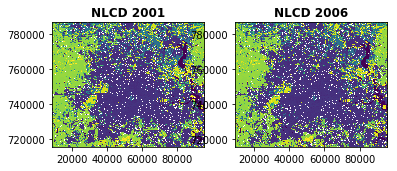

In [24]:
###########################################
###########################################
### PART I: READ AND VISUALIZE DATA #######
	
infile_land_cover_date1 = os.path.join(in_dir,infile_land_cover_date1) #NLCD 2001
infile_land_cover_date2 = os.path.join(in_dir,infile_land_cover_date2) #NLCD 2006
infile_land_cover_date3 = os.path.join(in_dir,infile_land_cover_date3) #NLCD 2011

lc_date1 = rasterio.open(infile_land_cover_date1) 
r_lc_date1 = lc_date1.read(1,masked=True) #read first array with masked value, nan are assigned for NA
lc_date2 = rasterio.open(infile_land_cover_date2) 
r_lc_date2 = lc_date2.read(1,masked=True) #read first array with masked value, nan are assigned for NA
lc_date3= rasterio.open(infile_land_cover_date2) 

#Generate quick visualization using rasterio object
f, ax = plt.subplots(1, 2)
plot.show(lc_date1,title="NLCD 2001",ax=ax[0])
plot.show(lc_date2,title="NLCD 2006",ax=ax[1])

print(type(lc_date1))
print("Coordinate reference system: ",lc_date1.crs ) 
      
print(" Rows and columns: ", lc_date1.shape, "number of rows: ", lc_date1.height)  

lc_legend_df = pd.read_csv(os.path.join(in_dir,infile_name_nlcd_legend),sep=",")
lc_legend_df.head() # Inspect data
lc_legend_df.columns
lc_legend_df.shape
#subset the data to remove unused rows
lc_legend_df = lc_legend_df[lc_legend_df['COUNT']>0] 


## PART 2: Analyze overall changes and land transitions

We analyze changes in the Houston area by comparing change in areas between the two dates (2001-2006). We can also examine the most common transitions between the land cover classes using crosstabulation. Before any analyses, we reclassifly the NLCD maps to simplify and generalizes the classes using NLCD Anderson level 1 classes.


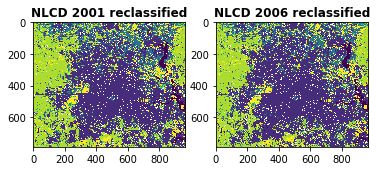

In [25]:
#######
################################################
###  PART II : Analyze overall changes and land transitions

## As the plot shows for 2006, we have 15 land cover types. Analyzing such complex categories in terms of decreasse (loss), increase (gain), 
## persistence in land cover will generate a large number of transitions (potential up to 15*15=225 transitions in this case!)
## To generalize the information, let's aggregate leveraging the hierachical nature of NLCD Anderson Classification system.

#### Step 1: aggregate NLCD classes

# Read in classification system: Now 15 land categories instead of 20.

lc_system_nlcd_df = pd.read_excel(os.path.join(in_dir,infile_name_nlcd_classification_system))
lc_system_nlcd_df.head() #inspect data

### Set up the reclassification
class_def = np.array([0,20,1,
                      20,30,2,
                      30,40,3,
                      40,50,4,
                      50,60,5,
                      60,70,6,
                      70,80,7,
                      80,90,8,
                      90,100,9])
 
class_def = class_def.reshape(9,3)

## Generate copies of raster objects
r_date1_rec = copy.copy(r_lc_date1)
r_date2_rec = copy.copy(r_lc_date2)

for i in np.arange(0,9):
    class_val = class_def[i,:]
    r_date1_rec[(class_val[0]<= r_date1_rec) & (r_date1_rec <class_val[1])] = class_val[2]
    r_date2_rec[(class_val[0]<= r_date2_rec) & (r_date2_rec <class_val[1])] = class_val[2]

f, ax = plt.subplots(1, 2)
plot.show(r_date1_rec,title="NLCD 2001 reclassified",ax=ax[0])
plot.show(r_date2_rec,title="NLCD 2006 reclassified",ax=ax[1])


## Examine overall changes in categories

We compute the frequency of each land cover classes for each NLCD map and generate a difference bewteen 2001 and 2006. We find that the most common change is an increase in urban areas. The largest decreases in the forest and herbaceous lands.


[Text(0, 0, 'Water'),
 Text(0, 0, 'Developed'),
 Text(0, 0, 'Barren'),
 Text(0, 0, 'Forest'),
 Text(0, 0, 'Shrubland'),
 Text(0, 0, 'Herbaceous'),
 Text(0, 0, 'Planted/Cultivated'),
 Text(0, 0, 'Wetlands')]

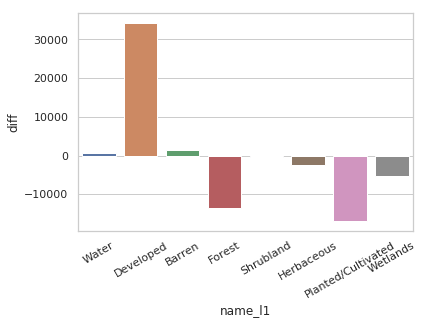

In [26]:
####### Step 2: Examine overall changes in categories

val, cnts =np.unique(r_date1_rec,return_counts=True)
df = pd.DataFrame(np.ma.filled(val))
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_date1 = pd.DataFrame(val,cnts)
df_date1 = df_date1.reset_index()
df_date1.columns = ['y_2001','value']

val, cnts =np.unique(r_date2_rec,return_counts=True)
df = pd.DataFrame(np.ma.filled(val))
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_date2 = pd.DataFrame(val,cnts)
df_date2 = df_date2.reset_index()
df_date2.columns = ['y_2006','value']

### Let's identify existing cover and compute change:
freq_tb_nlcd = pd.merge(df_date1,df_date2,on='value')
#reorder columns 
freq_tb_nlcd = freq_tb_nlcd[['value','y_2001','y_2006']]
freq_tb_nlcd['diff'] = freq_tb_nlcd['y_2006'] - freq_tb_nlcd['y_2001']
## link to category names
cat_val = lc_system_nlcd_df[['id_l1','name_l1']].drop_duplicates()

freq_tb_nlcd = pd.merge(freq_tb_nlcd,
                        cat_val,
                        left_on='value',
                        right_on='id_l1')
freq_tb_nlcd

## barplot
sns.set(style="whitegrid")
#tips = ns.load_dataset("tips")
ax = sns.barplot(x="name_l1", 
                     y="diff", 
                     data=freq_tb_nlcd)
ax.set_xticklabels(list(freq_tb_nlcd["name_l1"]),rotation=30)


## Method 2: Summarize using groupby aggregation and joining

This method uses "groupby" to aggregation information by census track using a summary function. We use here "sum" to generate summary at the census track level. Note that the output of the gropuby operation is a pandas DataFrame. The output table is then join to the census track level geopanda DataFrame using the track ID as the primary key. Before joing the datasets, we must ensure that the datatypes of both keys match and change the column data type us "astype" if necessary. The join operation is carried out using the merge function. 


In [28]:
##### Step 3: examine land transitions 
#### Crosstab

data_rec = pd.DataFrame({'date1': r_date1_rec.ravel(),
             'date2':

In [28]:
 r_date2_rec.ravel()})
rec_xtab_df= pd.crosstab(data_rec['date1'],data_rec['date2'])

#rec_xtab_df['class'] = rec_xtab_df.index
rec_xtab_df.columns = ['1.0','2.0','3.0','4.0','5.0','7.0','8.0','9.0']
rec_xtab_df.index = ['1.0','2.0','3.0','4.0','5.0','7.0','8.0','9.0']
print(rec_xtab_df)

rec_xtab_df.max() # diagonal is the max for all columns

rec_xtab_df['2.0']

## Look at transitions for class 2 (urban)
## Most common is from 8 to 2
## Planted cultived to urban
## Second biggest is from FOrest (4) to 2

       1.0     2.0   3.0    4.0    5.0    7.0     8.0    9.0
1.0  17285      74   176      8     34     95       3     38
2.0      7  325161    10     40     14     32      17     19
3.0    231    1111  2815     10     70    115       7     51
4.0     76   10115   386  77877    807    996     127    116
5.0     21    1364   232    192  13782    452      37     11
7.0     73    3243   145     27    752  16967      14     19
8.0    306   12540  1929     48    264    411  154887     52
9.0    302    3987   314     41     87     91     110  58478


1.0        74
2.0    325161
3.0      1111
4.0     10115
5.0      1364
7.0      3243
8.0     12540
9.0      3987
Name: 2.0, dtype: int64

## PART III: Process and prepare for land cover change modeling

In this section, we read in the datasets that will be used in the logistic regression to predict urban change in Houston over the 2001-2006 time period. The variables were preprocessed and we extract values at every pixel location. The dataset includes the following relevant columns:
- change: boolean, 1 for change to urban and 0 for no change 
- land cover 
- slope 
- road_dist 
- developed_dist 


In [29]:
###########################################
############# PART III: Process and prepare for land change modeling ####################
## add this later

### Let's read in the information that contains variables
data_df = pd.read_csv(os.path.join(in_dir,data_fname))
data_df.columns
data_df.head()

,change,land_cover,slope,roads_dist,developped_dist,prob,x,y
0,0,9,1.628,0.970,0.890,0.000,41400,786690
1,0,4,1.195,0.971,0.878,0.000,41490,786690
2,0,9,1.518,0.973,0.865,0.000,41580,786690
3,0,9,0.987,0.974,0.853,0.000,41670,786690
4,0,9,1.915,0.975,0.840,0.000,41760,786690


## PART 3: SPATIAL QUERY 

We generate a dataset with metals and lead information by census tracks.
This requires multiple steps. First, we need to join metals attribute to census tracks. Second, we generate a spatial object from the textfile of lead (PB) data. This files contains x and y coordinates that can be used to create a POINT geometry column using the shapely and geopandas packages.
The third step consists in joining the lead data to census tracks. This is done through a spatial join to associate point data with polygons identifiers containing them. The fourth step consists in using a summarize by operation ("groupby") to generate averages of lead ppm by census tracks.


,x,y,ID,ppm,Coordinates
0,408164.2892,4762321.061,0,3.890648,POINT (408164.2892 4762321.061000001)
1,405914.8759,4767394.274,1,4.899391,POINT (405914.8759 4767394.274)
2,405723.9622,4767705.893,2,4.434912,POINT (405723.9622 4767705.893)
3,406702.7734,4769200.832,3,5.285548,POINT (406702.7734 4769200.831999999)
4,405392.3004,4765598.492,4,5.295919,POINT (405392.3004 4765598.492)


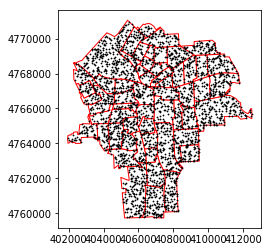

In [144]:
##### Step 1: Join metals to census tracks ###### 

metals_df.head()
metals_df.describe() # 57 rows  
##Number of rows suggests matching to the following spatial entities
metals_df.shape[0]== ct_2000_gpd.shape[0]
#Check data types before joining tables with "merge"
metals_df.dtypes
ct_2000_gpd.dtypes
ct_2000_gpd.shape
census_metals_gpd = ct_2000_gpd.merge(metals_df,left_on='TRACT',right_on='ID')
census_metals_gpd.shape #census information has been joined

##### Step 2: Generate geopanda from PB sample measurements ##### 
# Processing lead data to generate a geopanda object using shapely points

soil_PB_df.columns #Missing names for columns
soil_PB_df.columns = ["x","y","ID","ppm"]
soil_PB_df.head()

soil_PB_gpd = soil_PB_df.copy() # generate a new panda DataFrame object
type(soil_PB_gpd)
soil_PB_gpd['Coordinates']=list(zip(soil_PB_gpd.x,soil_PB_gpd.y)) #create a new column with tuples of coordinates
type(soil_PB_gpd)
soil_PB_gpd['Coordinates']= soil_PB_gpd.Coordinates.apply(Point) #create a point for each tupple row
type(soil_PB_gpd.Coordinates[0]) #This shows that we created a shapely geometry point
type(soil_PB_gpd) #This is still an panda DataFrame
soil_PB_gpd = gpd.GeoDataFrame(soil_PB_gpd,geometry='Coordinates') #Create a gpd by setting the geometry column
type(soil_PB_gpd) # This is now a GeoDataFrame

## Checking and setting the coordinates reference system
soil_PB_gpd.crs #No coordinate reference system (CRS) is set
census_metals_gpd.crs # Let's use the metal geopanda object to set the CRS

## Find out more about the CRS using the epsg code
epsg_code = census_metals_gpd.crs.get('init').split(':')[1]
inproj = osr.SpatialReference()
inproj.ImportFromEPSG(int(epsg_code))
inproj.ExportToProj4() # UTM 18: this is the coordinate system in Proj4 format
## Assign projection system
soil_PB_gpd.crs= census_metals_gpd.crs #No coordinate system is set
soil_PB_gpd.head()

## Now plot the points
fig, ax = plt.subplots()
census_metals_gpd.plot(ax=ax,color='white',edgecolor='red')
soil_PB_gpd.plot(ax=ax,marker='*',
                 color='black',
                 markersize=0.8)

soil_PB_gpd.head()

In [145]:
##### Step 3: Join lead (pb) measurements to census tracks #####
# Spatial query: associate points of pb measurements to each census tract

soil_PB_joined_gpd =gpd.tools.sjoin(soil_PB_gpd,census_2000_gpd,
                     how="left")
soil_PB_joined_gpd.columns
soil_PB_joined_gpd.shape #every point is associated with information from the census track it is contained in

len(soil_PB_joined_gpd.BKG_KEY.value_counts()) #associated BKG Key to points: 57 unique identifiers
len(soil_PB_joined_gpd.index_right.value_counts()) #associated BKG Key to points: 57 unique identifiers

#### Step 4: Find average lead by census track #####

grouped_PB_ct_df = soil_PB_joined_gpd[['ppm','TRACT','index_right']].groupby(['index_right']).mean() #compute average by census track
grouped_PB_ct_df = grouped_PB_ct_df.reset_index()
grouped_PB_ct_df.shape
grouped_PB_ct_df.head()

grouped_PB_ct_df = grouped_PB_ct_df.rename(columns={'ppm': 'pb_ppm' })
type(grouped_PB_ct_df)

census_metals_gpd = census_metals_gpd.merge(grouped_PB_ct_df,on="TRACT")
census_metals_gpd.shape
census_metals_gpd.columns #check for duplicate columns

outfile_metals_shp = "census_metals_pb_"+'_'+out_suffix+'.shp'
census_metals_gpd.to_file(os.path.join(outfile_metals_shp))

census_metals_df = pd.DataFrame(census_metals_gpd.drop(columns='geometry'))
outfile = "census_metals_pb_"+'_'+out_suffix+'.csv'

census_metals_df.to_csv(os.path.join(outfile))

census_metals_gpd.head()

,FIPS,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,Shape_Leng_x,Shape_Area_x,geometry,BKG_KEY,Shape_Leng_y,...,SSR,MRB,SRB,MZN,SZN,MPB,SPB,Tspbr,index_right,pb_ppm
0,36067000100,36,067,36067,100,13520.232628,6.135184e+06,"POLYGON ((403476.3667961732 4767681.659353677,...",360670001001,13520.232628,...,126.08,40.22,9.29,482.55,819.77,187.54,141.07,4.949256,0,4.928121
1,36067000300,36,067,36067,300,3664.906267,5.528384e+05,"POLYGON ((407273.7082073092 4770615.348040303,...",721340006003,5225.175499,...,126.21,53.21,9.66,239.04,117.44,190.25,125.28,4.830551,2,5.049756
2,36067000200,36,067,36067,200,4620.537302,1.084286e+06,"POLYGON ((405762.8405454708 4770677.466250783,...",721340004003,6038.106998,...,95.41,47.03,8.36,419.25,428.99,492.36,798.56,6.682810,1,5.377026
3,36067000400,36,067,36067,400,5931.046228,1.513148e+06,"POLYGON ((408398.5954386378 4769563.645143542,...",1442680016010,11971.493374,...,75.92,47.77,8.48,292.71,194.48,258.17,196.57,5.281019,3,4.756565
4,36067001000,36,067,36067,1000,5668.226852,1.237272e+06,"POLYGON ((409917.2280338025 4769065.286384709,...",1442680040010,10786.395771,...,35.50,47.20,7.79,220.03,129.71,133.34,74.52,4.311068,9,4.690085


## PART IV: Spatial regression: Vulnerability to metals 

In this section, we examine the relationship between lead and vulnerable populations in Syracuse using first a linear OLS regression and then a spatial lag regression model. Spatial datasets often contain autocorrelation and this must be taken into account when regression models are performed. In the first step, we explor the neighbor structure of the dataset using pysal objects.  In the econd step, we explore spatial autocorrelation using the Moran's I index.


Text(0.5, 1.0, 'Queen Neighbors links')

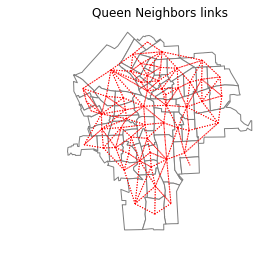

In [157]:
#################################################
##### PART IV: Spatial regression: Vulnerability to metals #############
#Examine the relationship between  Pb and vulnerable populations in Syracuse

######## Step 1: Explore neighbors with pysal

w = Queen.from_dataframe(census_metals_gpd)
type(w)
w.transform = 'r'
w.n # number of observations (spatial features)
census_metals_gpd.index #this is the index used for neighbors
w.neighbors # list of neighbours per census track
w.mean_neighbors #average number of neighbours

### Visualizaing neighbors:
ax = census_metals_gpd.plot(edgecolor='grey', 
                            facecolor='w')
f,ax = w.plot(census_metals_gpd, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', 
                      linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()
ax.set_title("Queen Neighbors links")




Text(0.5, 1.0, "Moran's scatter plot")

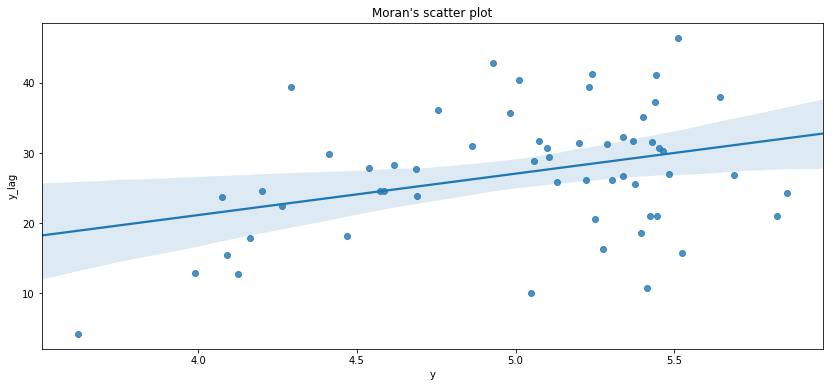

In [167]:
########## Step 2: Explore Moran's I ##########

#http://pysal.org/notebooks/viz/splot/esda_morans_viz
y = census_metals_gpd['pb_ppm'] 
#w_queen = ps.lib.weights.Queen.from_shapefile(outfile_metals_shp)
w_queen = ps.lib.weights.Queen.from_dataframe(census_metals_gpd)

y_lag = ps.model.spreg.lag_spatial(w_queen,y)
census_metals_gpd['y'] = census_metals_gpd['pb_ppm']
census_metals_gpd['y_lag'] = y_lag

fig, ax = plt.subplots(figsize=(14,6))

ax= sns.regplot(x='y',y='y_lag',data=census_metals_gpd)
ax.set_title("Moran's scatter plot")


0.001

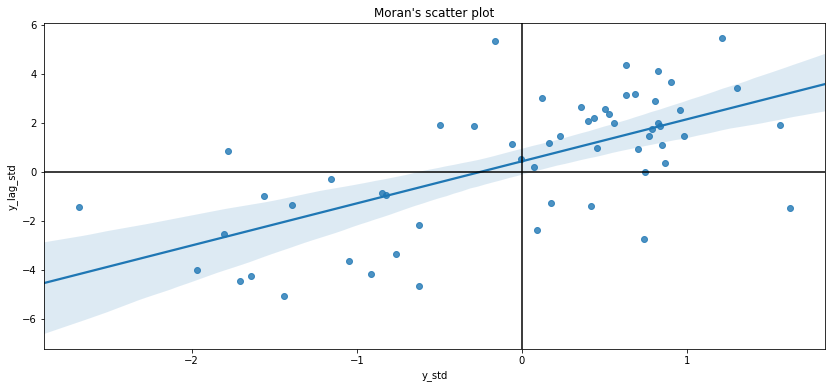

In [168]:
### Visualize the Moran's I with standardized values
scaler = StandardScaler()
census_metals_gpd['y_std'] = scaler.fit_transform(census_metals_gpd['pb_ppm'].values.reshape(-1,1))
census_metals_gpd['y_lag_std'] = ps.model.spreg.lag_spatial(w_queen,
                                                census_metals_gpd['y_std']) #this is a numpy array

fig, ax = plt.subplots(figsize=(14,6))

ax= sns.regplot(x='y_std',y='y_lag_std',data=census_metals_gpd)
ax.set_title("Moran's scatter plot")
ax.axhline(0, color='black')
ax.axvline(0, color='black')
#for more in depth understanding take a look at: http://darribas.org/gds15/content/labs/lab_06.html

#This suggests autocorrelation.
#Let's us Moran's I.

moran = Moran(y, w)
moran.I # Moran's I value
moran.p_sim # Permutation test suggests that autocorrelation is significant


In [166]:

########## Step 3: Spatial Regression ##########

y.values.shape #not the right dimension
y = y.values.reshape(len(y),1)

y_lag = y_lag.reshape(len(y_lag),1)
x = census_metals_gpd['perc_hispa']
x = x.values.reshape(len(x),1)

mod_ols = ps.model.spreg.OLS(y,x)
mod_ols.u 
m_I_residuals = ps.explore.esda.Moran(mod_ols.u,w_queen)
m_I_residuals.I
m_I_residuals.p_sim #significant autocorrelation

#take into account autocorr in spreg
print(mod_ols.summary)
mod_ols_test = ps.model.spreg.OLS(y,x,w_queen)
mod_ols_test.summary

mod_ml_lag = ps.model.spreg.ML_Lag(y,x,w_queen)
print(mod_ml_lag.summary)
mod_ml_lag.u
m_ml_I_residuals = ps.explore.esda.Moran(mod_ml_lag.u,w_queen)
m_ml_I_residuals.I # Moran's I is lower now!!!

m_ml_I_residuals.p_sim #not significant autocorrelation

################################## END OF SCRIPT ########################################


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     dep_var                Number of Observations:          57
Mean dependent var  :      5.0126                Number of Variables   :           2
S.D. dependent var  :      0.5238                Degrees of Freedom    :          55
R-squared           :      0.0383
Adjusted R-squared  :      0.0209
Sum squared residual:      14.777                F-statistic           :      2.1928
Sigma-square        :       0.269                Prob(F-statistic)     :      0.1444
S.E. of regression  :       0.518                Log likelihood        :     -42.405
Sigma-square ML     :       0.259                Akaike info criterion :      88.810
S.E of regression ML:      0.5092                Schwarz criterion     :      92.896

-----------------------------------------------------------------------------

/usr/local/lib/python3.5/dist-packages/scipy/optimize/_minimize.py:761: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


0.122

## Conclusions

In this exercise, we explored lead exposure in Syracuse. We used spatial information from the census and smaple points of lead collected at various locations. To generate a regression model, we went through a series of processing steps that are typical of geospatial workflows. This include operations such as join, dissolve, aggregation and spatial query based on locations. We explored  spatial autocorrelation using the Moran's I index. We found autocorrelation in the residuals of the OLS regressiona and specified a spatial regression model to take into account spatial autocorrelation. 

## References

PySAL: A Python Library of Spatial Analytical Methods, Rey, S.J. and L. Anselin, Review of Regional Studies 37, 5-27 2007.

Moran, P. A. P. (1950). "Notes on Continuous Stochastic Phenomena". Biometrika. 37 (1): 17–23. doi:10.2307/2332142. JSTOR 2332142.

Impacts of positional error on spatial regression analysis: a case study of address locations in Syracuse, New York. DA Griffith, M Millones, M Vincent, DL Johnson, A Hunt - Transactions in GIS, 2007

Cliff and Ord (1981), Spatial Processes, London
